In [2]:
pip install xgboost

     |████████████████████████████████| 686kB 2.3MB/s eta 0:00:01
  Stored in directory: /Users/sophiaperides/Library/Caches/pip/wheels/e9/48/4d/de4187b5270dff71d3697c5a7857a1e2d9a0c63a28b3462eeb
Successfully built xgboost
Note: you may need to restart the kernel to use updated packages.


In [130]:
# Set up & handling the data
import os
os.chdir('/Users/sophiaperides/Desktop/Thinkful')
import csv
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings(action="ignore")

# Cleaning the data
import re

# Transforming the data
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats.mstats import winsorize
import seaborn as sns
from sklearn.preprocessing import normalize
from sklearn import ensemble   # we'll use ensemble random forests


# Running the models
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
# from sklearn.metrics import precision_score, recall_score, accuracy_score

#Statistics
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt

# Not using these yet
# import re                                   # clean data
# from sklearn import linear_model
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import normalize
# import statsmodels.formula.api as smf
# from sqlalchemy import create_engine
# from scipy.stats import bartlett
# from scipy.stats import levene
# from statsmodels.tsa.stattools import acf
# import statsmodels.api as sm
# import seaborn as sns
# from statsmodels.tools.eval_measures import mse, rmse
# from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import mean_squared_error
# from math import sqrt
# from sklearn.linear_model import Lasso
# from sklearn.linear_model import Ridge
# from sklearn.linear_model import ElasticNet
# from sklearn.linear_model import LassoCV
# from sklearn.linear_model import RidgeCV
# from sklearn.linear_model import ElasticNetCV
# from sklearn.linear_model import LinearRegression


# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Introduction
Analyzing the IMDB Movie dataset, I'm going to look at if we can predict how successful a movie is using the adjusted revenue as the measure of success. With nearly 11,000 movies and twenty variables, I should be able to choose features correlated with the revenue to create a good model.

## Cleaning

There are 6,016 rows with an adjused revenue of $0. I'm going to remove these rows as

Columns homepage, director, cast, keywords, tagline, and production_companies are missing values. For the homepage column, I will assumme that a missing value indicates that a movie does not have a homepage. I'll create a dummy variable in which 0 indicates there is no homepage and 1 indicates that one exists. Only one movie is missing the director and five movies are missing the cast, so I will look up this information and manually add it to the dataset. I will set cells missing values for keywords, tagline, and production companies to 'Unknown'.

Off the bat, popularity, budget, revenue, runtime, and votecount have clear high outliers. I'm going to take a look at these columns and see if we can derive what may be going on. Cast, homepage, director, tagline, keywords, overview, genres, and production_companies are missing values. Nearly all of these contain categorical data so I will fill the values as best as I can and remove rows and/or columns I cannot.

In [11]:
movies = pd.read_csv('IMDBMovies.csv')
movies = pd.DataFrame(movies)
print(movies.columns)
print('\n', movies.describe())
movies.info()

Index(['id', 'imdb_id', 'popularity', 'budget', 'revenue', 'original_title',
       'cast', 'homepage', 'director', 'tagline', 'keywords', 'overview',
       'runtime', 'genres', 'production_companies', 'release_date',
       'vote_count', 'vote_average', 'release_year', 'budget_adj',
       'revenue_adj'],
      dtype='object')

               id  popularity        budget        revenue   runtime  \
count  10866.000   10866.000     10866.000      10866.000 10866.000   
mean   66064.177       0.646  14625701.094   39823319.793   102.071   
std    92130.137       1.000  30913213.831  117003486.582    31.381   
min        5.000       0.000         0.000          0.000     0.000   
25%    10596.250       0.208         0.000          0.000    90.000   
50%    20669.000       0.384         0.000          0.000    99.000   
75%    75610.000       0.714  15000000.000   24000000.000   111.000   
max   417859.000      32.986 425000000.000 2781505847.000   900.000   

       vote_count  vote_ave

In [12]:
# pd.options.display.max_columns = None
movies[movies['revenue_adj'] == 0 ].shape
# pd.options.display.max_columns = None
# movies.head()
movies = movies[movies.revenue_adj != 0]
print(movies.describe())
movies.info()
movies.head()

              id  popularity        budget        revenue  runtime  \
count   4850.000    4850.000      4850.000       4850.000 4850.000   
mean   44575.001       1.045  29569700.632   89220658.325  107.965   
std    72361.406       1.357  40513434.965  162068389.382   21.113   
min        5.000       0.001         0.000          2.000   15.000   
25%     8286.000       0.388   1700000.000    7708081.250   95.000   
50%    12154.500       0.680  15000000.000   31826540.000  104.000   
75%    43956.500       1.210  40000000.000   99918234.250  117.000   
max   417859.000      32.986 425000000.000 2781505847.000  705.000   

       vote_count  vote_average  release_year    budget_adj    revenue_adj  
count    4850.000      4850.000      4850.000      4850.000       4850.000  
mean      436.216         6.149      2000.922  35161017.182  115077354.868  
std       806.416         0.799        11.569  43756717.053  198841916.046  
min        10.000         2.100      1960.000         0.000  

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.986,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/2015,5562,6.500,2015,137999939.300,1392445893.000
1,76341,tt1392190,28.420,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/2015,6185,7.100,2015,137999939.300,348161292.500
2,262500,tt2908446,13.113,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/2015,2480,6.300,2015,101199955.500,271619025.400
3,140607,tt2488496,11.173,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,...,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/2015,5292,7.500,2015,183999919.000,1902723130.000
4,168259,tt2820852,9.335,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,...,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/2015,2947,7.300,2015,174799923.100,1385748801.000


## Genres Variable
The contents in the genres column contain multiple genres separated by the a symbol. I'm going to separate the genres in each cell, find all unique values, and create a dummy column for each genre. If a movie contains (?) that genre, the column will have the value one in the corresponding cell. Otherwise, the column for that movie will contain a zero.

In [13]:

# Create a list of the genres

Genres = movies.genres.unique()
genres = []
flatten_genres = []

for list_of_genres in Genres:
    movies_genres = list_of_genres.split('|')
    genres.append(movies_genres)
    for i in range(len(genres)): #Traversing through the main list
        for j in range (len(genres[i])): #Traversing through each sublist
            flatten_genres.append(genres[i][j]) #Appending elements into our flat_list

unique_genres = set(flatten_genres)
print(unique_genres)

# Creating dummy columns for each genre
for genre in unique_genres:
    movies[genre] = 0 

{'Comedy', 'Foreign', 'Horror', 'Adventure', 'Animation', 'War', 'Drama', 'Music', 'Documentary', 'Crime', 'Fantasy', 'Mystery', 'Science Fiction', 'Romance', 'History', 'Action', 'Western', 'Family', 'TV Movie', 'Thriller'}


In [14]:
# Populating each genre column
def populating_genres(df, genre_list):
    for i, row in df.iterrows():
        movies_genres = df.loc[i]['genres']
        for genre in genre_list:
            if genre in movies_genres:
                df.at[i, genre] = 1
    return df

populating_genres(movies, unique_genres)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,Fantasy,Mystery,Science Fiction,Romance,History,Action,Western,Family,TV Movie,Thriller
0,135397,tt0369610,32.986,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,0,0,1,0,0,1,0,0,0,1
1,76341,tt1392190,28.420,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,0,0,1,0,0,1,0,0,0,1
2,262500,tt2908446,13.113,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,0,0,1,0,0,0,0,0,0,1
3,140607,tt2488496,11.173,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,...,1,0,1,0,0,1,0,0,0,0
4,168259,tt2820852,9.335,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,...,0,0,0,0,0,1,0,0,0,1
5,281957,tt1663202,9.111,135000000,532950503,The Revenant,Leonardo DiCaprio|Tom Hardy|Will Poulter|Domhn...,http://www.foxmovies.com/movies/the-revenant,Alejandro González Iñárritu,"(n. One who has returned, as if from the dead.)",...,0,0,0,0,0,0,1,0,0,1
6,87101,tt1340138,8.654,155000000,440603537,Terminator Genisys,Arnold Schwarzenegger|Jason Clarke|Emilia Clar...,http://www.terminatormovie.com/,Alan Taylor,Reset the future,...,0,0,1,0,0,1,0,0,0,1
7,286217,tt3659388,7.667,108000000,595380321,The Martian,Matt Damon|Jessica Chastain|Kristen Wiig|Jeff ...,http://www.foxmovies.com/movies/the-martian,Ridley Scott,Bring Him Home,...,0,0,1,0,0,0,0,0,0,0
8,211672,tt2293640,7.404,74000000,1156730962,Minions,Sandra Bullock|Jon Hamm|Michael Keaton|Allison...,http://www.minionsmovie.com/,Kyle Balda|Pierre Coffin,"Before Gru, they had a history of bad bosses",...,0,0,0,0,0,0,0,1,0,0
9,150540,tt2096673,6.327,175000000,853708609,Inside Out,Amy Poehler|Phyllis Smith|Richard Kind|Bill Ha...,http://movies.disney.com/inside-out,Pete Docter,Meet the little voices inside your head.,...,0,0,0,0,0,0,0,1,0,0


## Cast Variable
Each cell in the cast column has up to the five central actors and/or actresses in the movie. I have found a list of the top 100 movie stars from 1960 and to make use of this variable, I will create a new feature called 'stars' which holds the number of actors each movie has from this list. We would expect to see that movies with any/more stars than others would be more successful.

In [15]:
# Adding the missing top five cast members
movies[movies['cast'].isnull()]
movies.at[1088, 'cast'] = 'Vivian Maier|John Maloof|Daniel Arnaud|Simone Amédé|Maren Baylaender'
movies.at[4127, 'cast'] = 'Belladonna|Marlon Brando|Elton John|Julia Louis-Dreyfus|Madonna'
movies.at[4889, 'cast'] = 'Jay Bastian|Joe Biden|Cait Brasel|Gene Burris Jr.|Dinesh D\'Souza'
movies.at[7813, 'cast'] = 'Dylan Avery|Mahmoud Ahmad|Ahmed Al-Ghamdi|Hamza Al-Ghamdi|Saeed Al-Ghamdi'
movies.at[9564, 'cast'] = 'Christie Brinkley|David Brinkley|Pope John Paul II|Dan Rather|Cheryl Tiegs'
movies[movies['cast'].isnull()]

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,Fantasy,Mystery,Science Fiction,Romance,History,Action,Western,Family,TV Movie,Thriller


In [16]:
# Splitting the cast information into lists
movies['cast'] = movies['cast'].apply(lambda x: x.split('|'))

In [17]:
## Create a list of actors

Cast = movies.cast # a list of the list of cast members in each movie
cast = [] # 
flatten_cast = []

for list_of_actors in Cast: 
    cast.append(list_of_actors)
    for i in range(len(cast)): #Traversing through the main list
        for j in range (len(cast[i])): #Traversing through each sublist
            flatten_cast.append(cast[i][j]) #Appending elements into our flat_list

unique_actors = set(flatten_cast)


In [23]:
# cleaning names - finding actor's names with non-alphanumeric characters
unique_actors = list(unique_actors)
print(type(unique_actors)) 
non_alphanumeric = [i for i in unique_actors if not i.lower().replace(" ", "").replace('\'', '').replace('.', '')
                    .replace('-', '').replace(',','').replace('ÃƒÂ¥', 'å').replace('ÃƒÂ¡', 'á').replace('ÃƒÂ\xad', 'í')
                    .isalpha()]
print('\n \n Names with non-alphanumeric characters:\n ', non_alphanumeric)

<class 'list'>

 
 Names with non-alphanumeric characters:
  ['Antonio SabÃƒÂ\xa0to, Jr.', 'JōÂ«rōta Kosugi', 'Jordi MollÃƒÂ\xa0', 'Ã\xa0Â¸ÂªÃ\xa0Â¸Â£Ã\xa0Â¸Å¾Ã\xa0Â¸â€¡Ã\xa0Â¸Â©Ã\xa0Â¹Å’ Ã\xa0Â¸Å\xa0Ã\xa0Â¸Â²Ã\xa0Â¸â€¢Ã\xa0Â¸Â£Ã\xa0Â¸Âµ', 'Linh āan PhÃ¡ÂºÂ¡m', '50 Cent', 'āềâ€” Thềâ€¹ HÃ¡ÂºÂ£i YÃ¡ÂºÂ¿n']


In [20]:
# Importing the top 100 stars and removing 'Actor' and 'Actress' so we just have names in the stars dataframe

top_100_actors = pd.read_csv('top_100_stars.csv')
top_100_actors = pd.DataFrame(top_100_actors)


top_100_actors['Name'] = top_100_actors['Name'].str.replace(' Actor', '')
top_100_actors['Name'] = top_100_actors['Name'].str.replace(' Actress', '')

# Converting the series to a list so we can compare it to the cast lists
top_100_actors = top_100_actors['Name'].tolist()
top_100_actors[:5]

movies['top_100_actors'] = [len(set(i) & set(top_100_actors)) for i in movies['cast']]
print('Number of movies for each number of stars (0-5): \n', movies.top_100_actors.value_counts())

Number of movies for each number of stars (0-5): 
 0    4022
1     679
2     134
3      14
4       1
Name: top_100_actors, dtype: int64


## Tagline Variable
For this variable, I will create a new column called 'tagline_score' for the number of words in the tagline to see if there is any correlation between tagline length and revenue. A cell will contain a zero if there are fewer than six words in a tagline, a one if there are more, and a two if there is no tagline in the data. My hypothesis is that movies with shorter taglines fare better - short and sweet is key!

In [21]:
movies['tagline'] = movies['tagline'].apply(lambda x: 'Unknown' if pd.isnull(x) else x)
movies['tagline'] = movies['tagline'].str.split(' ')
movies['tagline_length'] = movies['tagline'].apply(lambda x: 0 if len(x) < 6  else 1 if len(x) >= 6 else 2)
movies.head(2)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,Science Fiction,Romance,History,Action,Western,Family,TV Movie,Thriller,top_100_actors,tagline_length
0,135397,tt0369610,32.986,150000000,1513528810,Jurassic World,"[Chris Pratt, Bryce Dallas Howard, Irrfan Khan...",http://www.jurassicworld.com/,Colin Trevorrow,"[The, park, is, open.]",...,1,0,0,1,0,0,0,1,0,0
1,76341,tt1392190,28.420,150000000,378436354,Mad Max: Fury Road,"[Tom Hardy, Charlize Theron, Hugh Keays-Byrne,...",http://www.madmaxmovie.com/,George Miller,"[What, a, Lovely, Day.]",...,1,0,0,1,0,0,0,1,1,0


## Homepage Variable
I will create a dummy variable that reflects whether or not a movie has a homepage. This column will contain a one if a movie has a homepage and a zero if it does not.

In [22]:
movies['homepage_dummy'] = movies['homepage'].apply(lambda x: 0 if pd.isnull(x) else 1)

## Production Companies Variable
I'm not sure yet how to handle this variable, but will fill any empty cells with 'Unknown' for now.

In [26]:
movies['production_companies'] = movies['production_companies'].apply(lambda x: 'Unknown' if pd.isnull(x) else x)
print('There are', len(movies['production_companies'].unique()), 'production companies.')

There are 3683 production companies.


## Keywords Variable
I'm not sure yet how to handle this variable, but will fill any empty cells with 'Unknown' for now.

In [28]:
movies['keywords'] = movies['keywords'].apply(lambda x: 'Unknown' if pd.isnull(x) else x)
print('There are', len(movies[movies['keywords'] == 'Unknown']), 'movies with no keywords.')

There are 235 movies with no keywords.


## Director Variable
One movie is missing its director, so I will manually add it.

In [29]:
movies.director.isnull()
movies.at[1088, 'director'] = 'Aziz Mirza'
print('There are', len(movies.director.unique()), 'unique directors.')

There are 2134 unique directors.


## Correlation Matrix
Our first look at the correlation matrix provides some insight into the relationships between the variables and our arget, the adjusted revenue. There are strong relationships between budget and popularity which is intuitive, but there's quite a strong correlation between vote count, stronger even than the average vote which is interesting. Vote count and popularity (the average number of visits the IMDB page receives per week) are strongly correlated so I'm going to combine them into a single feature. Family and Animation genres have a fairly strong correlation at 0.516, so I'll combine them as well.

The features I'll start with are vc_pop (the combination of vote_count and popularity), budget_adj, runtime, vote_average, number_of_stars, and Adventure.

In [30]:
movies.corr()

,id,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj,...,Romance,History,Action,Western,Family,TV Movie,Thriller,top_100_actors,tagline_length,homepage_dummy
id,1.000,0.140,-0.068,-0.041,-0.031,0.070,0.008,0.507,-0.146,-0.115,...,-0.042,-0.007,-0.089,-0.013,-0.048,-0.006,-0.038,-0.099,-0.142,0.148
popularity,0.140,1.000,0.481,0.629,0.201,0.788,0.289,0.170,0.440,0.562,...,-0.072,-0.020,0.162,-0.005,0.064,-0.008,0.047,0.083,-0.039,0.248
budget,-0.068,0.481,1.000,0.704,0.247,0.586,0.037,0.238,0.964,0.561,...,-0.102,0.021,0.278,0.037,0.188,-0.009,0.032,0.108,-0.058,0.223
revenue,-0.041,0.629,0.704,1.000,0.238,0.764,0.207,0.121,0.674,0.905,...,-0.057,-0.022,0.177,-0.012,0.180,-0.004,-0.016,0.126,-0.040,0.237
runtime,-0.031,0.201,0.247,0.238,1.000,0.252,0.308,-0.100,0.304,0.264,...,0.028,0.259,0.082,0.082,-0.163,-0.013,0.017,0.234,0.013,0.035
vote_count,0.070,0.788,0.586,0.764,0.252,1.000,0.351,0.197,0.533,0.667,...,-0.091,-0.017,0.196,0.002,0.060,-0.007,0.032,0.094,-0.051,0.297
vote_average,0.008,0.289,0.037,0.207,0.308,0.351,1.000,-0.095,0.049,0.242,...,0.004,0.087,-0.102,0.037,-0.019,-0.010,-0.086,0.151,0.047,0.100
release_year,0.507,0.170,0.238,0.121,-0.100,0.197,-0.095,1.000,0.083,-0.100,...,-0.011,-0.036,-0.054,-0.089,-0.009,-0.006,-0.002,-0.220,-0.192,0.410
budget_adj,-0.146,0.440,0.964,0.674,0.304,0.533,0.049,0.083,1.000,0.593,...,-0.101,0.053,0.298,0.050,0.187,-0.009,0.038,0.158,-0.026,0.149
revenue_adj,-0.115,0.562,0.561,0.905,0.264,0.667,0.242,-0.100,0.593,1.000,...,-0.050,-0.009,0.174,0.001,0.165,-0.004,-0.007,0.187,-0.002,0.165


In [31]:
movies['vc_pop'] = movies['vote_count'] * movies['popularity']
corr_mat = movies.corr().loc[:, ["revenue_adj"]].sort_values(by='revenue_adj', ascending=False)
corr_mat

,revenue_adj
revenue_adj,1.000
revenue,0.905
vote_count,0.667
budget_adj,0.593
popularity,0.562
budget,0.561
vc_pop,0.478
Adventure,0.305
runtime,0.264
vote_average,0.242


## Testing for Outliers and Normality
The Jarque Bera and Normality tests produce p-values of or extremely close to zero. However, when I plot the features it is clear that they are not normal and have outliers. How/why is this possible?

A note on outliers: the extreme values in vc_pop seem to be legitimate - neither the vote_count nor the popularity appear to be errors budget_adj - legit, did the research for the top couple movies

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.



 Outlier Visualization for revenue_adj feature. 






'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


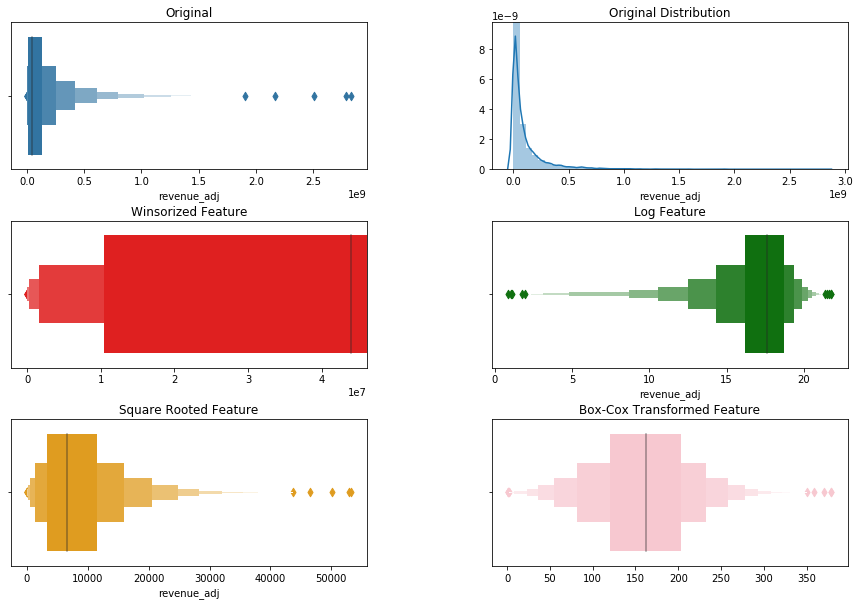

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.



 Outlier Visualization for vc_pop feature. 





'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


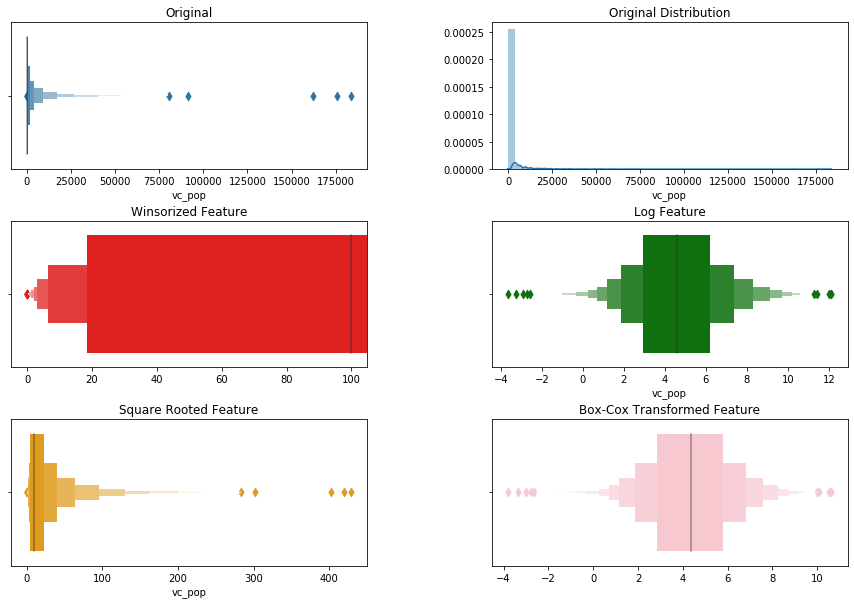

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


budget_adj Data isn't positive.

 Outlier Visualization for budget_adj feature. 





'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


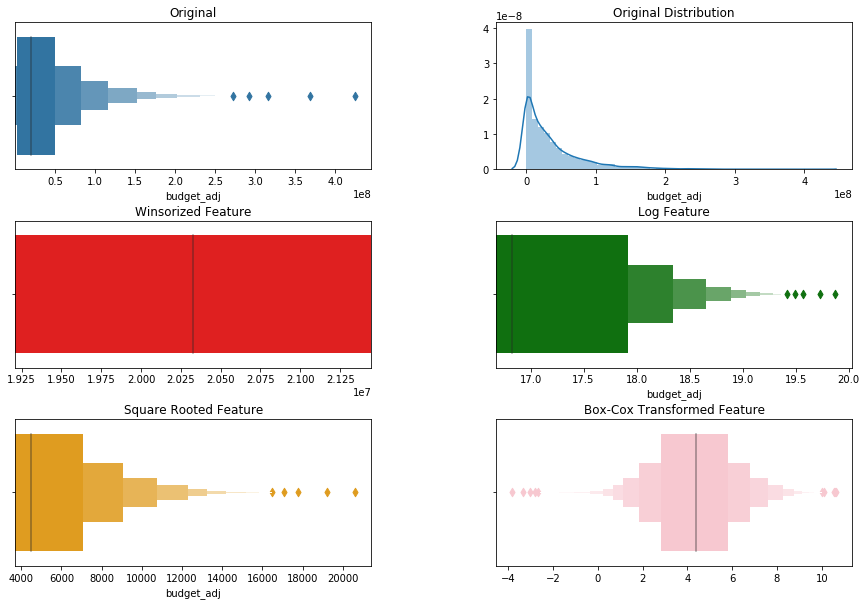


 Outlier Visualization for runtime feature. 



'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


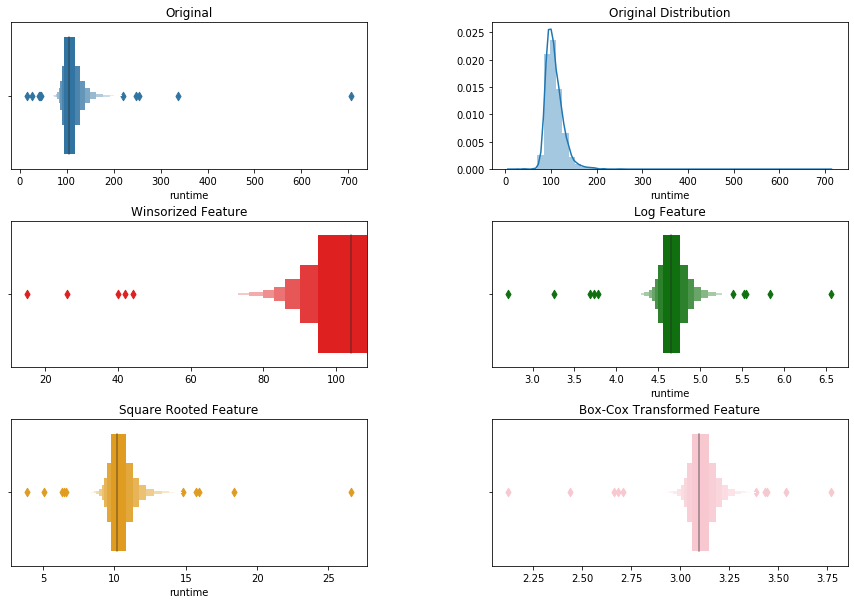

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.



 Outlier Visualization for vote_average feature. 





'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


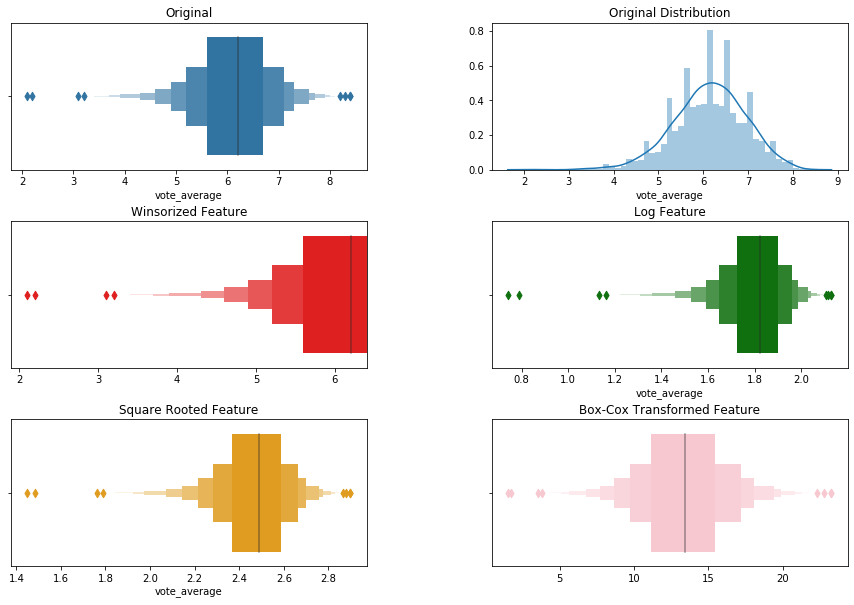

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


top_100_actors Data isn't positive.

 Outlier Visualization for top_100_actors feature. 





'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


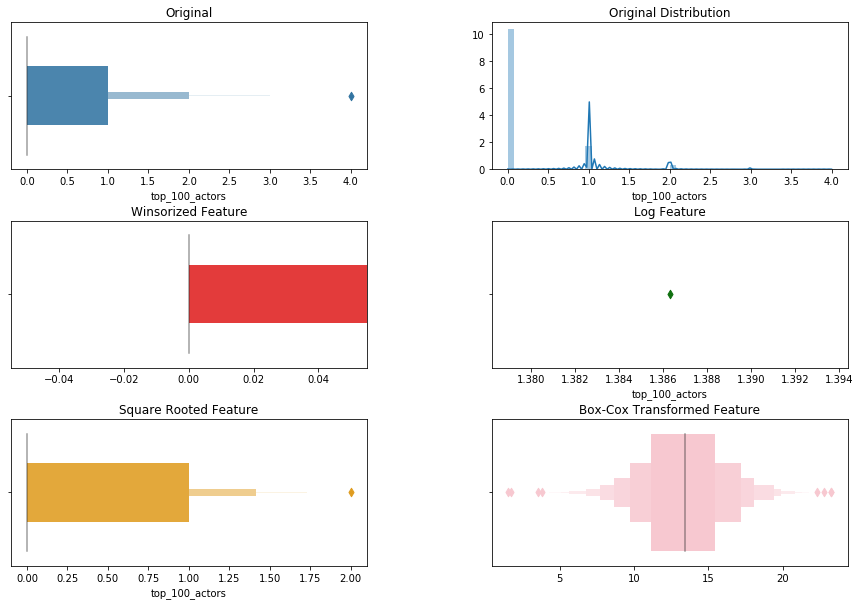

In [32]:
# Specify a list with features I want to test for normality. 
# Visuals for outliers and normality
features_to_test = ['revenue_adj','vc_pop', 'budget_adj', 'runtime', 'vote_average', 'top_100_actors', ]

for feat in features_to_test:
    winsorized_feature = winsorize(movies[feat], (0, 0.10))
    log_feature = np.log(movies[feat])
    sqrt_feature = np.sqrt(movies[feat])
    try:
        bc_feature,_ = stats.boxcox(movies[feat])#power_transform(np.array(fifa["Wage"]).reshape(1,-1)).reshape(-1,1)
    except ValueError: 
        print(feat, 'Data isn\'t positive.')
    
    print('\n Outlier Visualization for', feat, 'feature. \n')
    plt.figure(figsize = (15,10))
    plt.subplot(3, 2, 1)
    sns.boxenplot(x=feat, data=movies)
    plt.title('Original')
    print('\n')
    plt.subplot(3, 2, 2)
    sns.distplot(movies[feat])
    plt.title('Original Distribution')
    print('\n')
    plt.subplot(3, 2, 3)
    sns.boxenplot(winsorized_feature, color='red')
    plt.title('Winsorized Feature')
    plt.subplot(3, 2, 4)
    sns.boxenplot(log_feature, color='green')
    plt.title('Log Feature')
    print('\n')
    plt.subplot(3, 2, 5)
    sns.boxenplot(sqrt_feature, color='orange')
    plt.title('Square Rooted Feature')
    plt.subplot(3, 2, 6)
    sns.boxenplot(bc_feature, color='pink')
    plt.title('Box-Cox Transformed Feature')
    plt.subplots_adjust(hspace=0.35, wspace=0.35)
    plt.show()

In [33]:
# Testing for Normality

for feat in features_to_test:
    jb_stats = stats.jarque_bera(movies[feat])
    norm_stats = stats.normaltest(movies[feat])
    
    print("Testing for normality on {}:".format(feat))
    print('Jarque-Bera test statistics for', feat, 'is {0} and p value is {1}'.format(jb_stats[0], jb_stats[1]))
    print('Normality test statistics for', feat, 'is {0} and p value is {1}\n'.format(norm_stats[0], norm_stats[1]))

Testing for normality on revenue_adj:
Jarque-Bera test statistics for revenue_adj is 226940.3455244923 and p value is 0.0
Normality test statistics for revenue_adj is 4522.292435228974 and p value is 0.0

Testing for normality on vc_pop:
Jarque-Bera test statistics for vc_pop is 27345131.383749064 and p value is 0.0
Normality test statistics for vc_pop is 9645.87772348386 and p value is 0.0

Testing for normality on budget_adj:
Jarque-Bera test statistics for budget_adj is 10959.419887756596 and p value is 0.0
Normality test statistics for budget_adj is 2133.926912739724 and p value is 0.0

Testing for normality on runtime:
Jarque-Bera test statistics for runtime is 3797640.9538830956 and p value is 0.0
Normality test statistics for runtime is 5921.175938826389 and p value is 0.0

Testing for normality on vote_average:
Jarque-Bera test statistics for vote_average is 112.99050060716442 and p value is 0.0
Normality test statistics for vote_average is 102.28513371965839 and p value is 6.1

## Update Variable Values
As I was visualizing the data, there were a few values that warranted further investigation, so I have updated them here.

In [35]:
# The budget_adj for The Warrior's way appears to have an extra 0 - multiple sources have the budget at $42 million
movies.loc[2244, 'budget_adj'] = 42500000

# Band of Brothers and Carlos are miniseries which accounts for their lengthy runtimes.
# We're only interested in movies, so I'll remove them from the dataset.
movies = movies[movies.runtime < 338]

movies.sort_values(by='vote_average', ascending=False).head(2)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,History,Action,Western,Family,TV Movie,Thriller,top_100_actors,tagline_length,homepage_dummy,vc_pop
4178,278,tt0111161,7.192,25000000,28341469,The Shawshank Redemption,"[Tim Robbins, Morgan Freeman, Bob Gunton, Will...",NaN,Frank Darabont,"[Fear, can, hold, you, prisoner., Hope, can, s...",...,0,0,0,0,0,0,1,1,0,41382.992
7948,24128,tt0088178,0.283,1200000,4978922,Stop Making Sense,"[David Byrne, Tina Weymouth, Chris Frantz, Jer...",NaN,Jonathan Demme,"[Why, stop, making, sense?, Why, a, movie?, Wh...",...,0,0,0,0,0,0,0,1,0,6.513


## Normalizing the Features

In [36]:
movies["norm_winsorized_revenue_adj"] = normalize(np.array(winsorize(movies['revenue_adj'], (0, 0.10))).reshape(1,-1)).reshape(-1,1)
movies["norm_winsorized_vc_pop"] = normalize(np.array(winsorize(movies['vc_pop'], (0, 0.10))).reshape(1,-1)).reshape(-1,1)
movies["norm_sqrt_budget_adj"] = normalize(np.array(np.sqrt(movies['budget_adj'])).reshape(1,-1).reshape(-1,1))
movies["norm_winsorized_runtime"] = normalize(np.array(winsorize(movies['runtime'], (0, 0.10))).reshape(1,-1)).reshape(-1,1)
movies["norm_winsorized_vote_average"] = normalize(np.array(winsorize(movies['vote_average'], (0, 0.10))).reshape(1,-1)).reshape(-1,1)
movies["norm_winsorized_100_actors"] = normalize(np.array(winsorize(movies['top_100_actors'], (0, 0.10))).reshape(1,-1)).reshape(-1,1)

In [37]:
# Testing for Normality
features_to_test = ['norm_winsorized_revenue_adj', 'vc_pop', 'budget_adj', 'runtime', 'vote_average', 'top_100_actors', 'Adventure']

# Now run each and one of the featues in above list. Locate the features in your data and calculate the statistics. 
for feat in features_to_test:
    jb_stats = stats.jarque_bera(movies[feat])
    norm_stats = stats.normaltest(movies[feat])
    
    print("Testing for normality on {}:".format(feat))
    print('Jarque-Bera test statistics for', feat, 'is {0} and p value is {1}'.format(jb_stats[0], jb_stats[1]))
    print('Normality test statistics for', feat, 'is {0} and p value is {1}\n'.format(norm_stats[0], norm_stats[1]))

Testing for normality on norm_winsorized_revenue_adj:
Jarque-Bera test statistics for norm_winsorized_revenue_adj is 1123.713683320344 and p value is 0.0
Normality test statistics for norm_winsorized_revenue_adj is 732.9389443861746 and p value is 6.987638685634258e-160

Testing for normality on vc_pop:
Jarque-Bera test statistics for vc_pop is 27312141.12901556 and p value is 0.0
Normality test statistics for vc_pop is 9641.034782879604 and p value is 0.0

Testing for normality on budget_adj:
Jarque-Bera test statistics for budget_adj is 8349.283276825254 and p value is 0.0
Normality test statistics for budget_adj is 1978.5585603222419 and p value is 0.0

Testing for normality on runtime:
Jarque-Bera test statistics for runtime is 5253.912712582582 and p value is 0.0
Normality test statistics for runtime is 1377.889780564115 and p value is 6.237862752850362e-300

Testing for normality on vote_average:
Jarque-Bera test statistics for vote_average is 113.7014676333856 and p value is 0.0

In [38]:
movies.corr().loc[:, ["norm_winsorized_revenue_adj"]].sort_values(by='norm_winsorized_revenue_adj', ascending=False)

,norm_winsorized_revenue_adj
norm_winsorized_revenue_adj,1.000
revenue_adj,0.808
revenue,0.761
budget_adj,0.658
norm_winsorized_vc_pop,0.641
budget,0.607
vote_count,0.583
popularity,0.498
vc_pop,0.327
runtime,0.301


# Running the Models
All cross validation models will be run with ten folds, and all models using training and testing sets will use a 70%/30% split unless otherwise specified. Each round of models will test a new set of features.

## The First Round
For our first run, I'll use all features that have correlations of greater than 0.2 with the target variable, revenue_adj.

In [187]:
features1 = movies[['norm_winsorized_vc_pop', 'budget_adj', 'runtime',
                  'Adventure', 'norm_winsorized_100_actors', 'norm_winsorized_vote_average']]
target = movies['norm_winsorized_revenue_adj']
X_train, X_test, Y_train, Y_test = train_test_split(features1, target, test_size = .3, random_state = 465)
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

In [188]:
D_train = xgb.DMatrix(X_train, label=Y_train)
D_test = xgb.DMatrix(X_test, label=Y_test)

## Random Forests Ensemble with Cross Validation
With scores ranging from 0.19 to 0.71 and an average of .57, we can see that while this model accounts for 57% of the data, it is not very precise or accurate.

In [43]:
rfr = ensemble.RandomForestRegressor(n_estimators=200)

cross_val_score(rfr, features1, target, cv=10)

array([0.5942233 , 0.6489285 , 0.70852931, 0.66923549, 0.64960135,
       0.64236944, 0.59726132, 0.53542858, 0.45410966, 0.19366823])

## OLS with SKlearn & Training Sets
The OLS model gives R-squared/adjusted values of 0.56 for the training set and 0.59 for the testing set. All of our evaluation metrics are fairly low with the exception of the mean absolute percentage error of the prediction.

In [45]:
print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# We fit an OLS model using sklearn

ols = LinearRegression().fit(X_train_const, Y_train)

results_train = sm.OLS(Y_train, X_train_const).fit()
results_test = sm.OLS(Y_test, X_test_const).fit()
# We print the summary results
print(results_train.summary())
print('\n')
print(results_test.summary())
print('\n')

# We are making predictions here
Y_preds_train = ols.predict(X_train_const)
Y_preds_test = ols.predict(X_test_const)


print("R-squared of the model on the training set is: {}".format(ols.score(X_train_const, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ols.score(X_test_const, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

The number of observations in training set is 3393
The number of observations in test set is 1455
                                 OLS Regression Results                                
Dep. Variable:     norm_winsorized_revenue_adj   R-squared:                       0.565
Model:                                     OLS   Adj. R-squared:                  0.564
Method:                          Least Squares   F-statistic:                     733.1
Date:                         Sun, 01 Dec 2019   Prob (F-statistic):               0.00
Time:                                 17:21:27   Log-Likelihood:                 11970.
No. Observations:                         3393   AIC:                        -2.393e+04
Df Residuals:                             3386   BIC:                        -2.388e+04
Df Model:                                    6                                         
Covariance Type:                     nonrobust                                         
                      

## Lasso Regression Model
The Lasso model with training sets performs much more poorly than the OLS model in terms of all evaluation metrics. Perhaps using the Lasso with cross validation will fare better.

In [44]:
print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))
print('\n')

X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

lassoregr = Lasso(alpha=1000)
#lassoregr = Lasso(alpha=.01)
# lassoregr = Lasso(alpha=.1)
# lassoregr = Lasso(alpha=.5)
# lassoregr = Lasso(alpha=1)
# lassoregr = Lasso(alpha=5) 
lassoregr.fit(X_train_const, Y_train)

# We are making predictions here
Y_preds_train = lassoregr.predict(X_train_const)
Y_preds_test = lassoregr.predict(X_test_const)

print("R-squared of the model on the training set is: {}".format(lassoregr.score(X_train_const, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X_test_const, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

The number of observations in training set is 3393
The number of observations in test set is 1455


R-squared of the model on the training set is: 0.4229582810613107
-----Test set statistics-----
R-squared of the model on the test set is: 0.45186070623863034
Mean absolute error of the prediction is: 0.005892761452764114
Mean squared error of the prediction is: 6.464492622273607e-05
Root mean squared error of the prediction is: 0.008040206851986836
Mean absolute percentage error of the prediction is: 2152777.5355068725


## Lasso Regression Model with Cross Validation
The difference between the Lasso with cross validation and training/testing sets appears to be insignificant.

In [46]:
print('Lasso Regression with Cross Validation:')
lassoregrCV = LassoCV(n_alphas=5)
lassoregrCV.fit(X_train_const, Y_train)

# We are making predictions here
Y_preds_train = lassoregrCV.predict(X_train_const)
Y_preds_test = lassoregrCV.predict(X_test_const)

print("R-squared of the model on the training set is: {}".format(lassoregrCV.score(X_train_const, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregrCV.score(X_test_const, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

Lasso Regression with Cross Validation:
R-squared of the model on the training set is: 0.42296230307330046
-----Test set statistics-----
R-squared of the model on the test set is: 0.4520330238612169
Mean absolute error of the prediction is: 0.005889211987064724
Mean squared error of the prediction is: 6.462460390662817e-05
Root mean squared error of the prediction is: 0.008038942959533186
Mean absolute percentage error of the prediction is: 2148323.089311301


## Ridge Regression with Training/Testing Sets
The Ridge model performs much more in line with the first two models, so I will continue to test with it as we change our features.

In [47]:
# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced.
ridgeregr = Ridge(alpha=0.1) 
ridgeregr.fit(X_train_const, Y_train)

# We are making predictions here
Y_preds_train = ridgeregr.predict(X_train_const)
Y_preds_test = ridgeregr.predict(X_test_const)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train_const, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test_const, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

R-squared of the model on the training set is: 0.5566207650296846
-----Test set statistics-----
R-squared of the model on the test set is: 0.5777739932023411
Mean absolute error of the prediction is: 0.005092079284126279
Mean squared error of the prediction is: 4.979531547803577e-05
Root mean squared error of the prediction is: 0.007056579587734824
Mean absolute percentage error of the prediction is: 1479516.8444044322


## Ridge Regression with Cross Validation
There is not much of a difference between the Ridge with training sets and the Ridge with cross validation.

In [51]:
ridgeCV = RidgeCV(alphas=(0, 10), cv=10)
ridgeCV.fit(X_train_const, Y_train)

# We are making predictions here
Y_preds_train = ridgeCV.predict(X_train_const)
Y_preds_test = ridgeCV.predict(X_test_const)

print("R-squared of the model on the training set is: {}".format(ridgeCV.score(X_train_const, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeCV.score(X_test_const, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

R-squared of the model on the training set is: 0.5650241395984991
-----Test set statistics-----
R-squared of the model on the test set is: 0.5831017231038338
Mean absolute error of the prediction is: 0.0049698898754922255
Mean squared error of the prediction is: 4.91669884992248e-05
Root mean squared error of the prediction is: 0.0070119176049940005
Mean absolute percentage error of the prediction is: 1207876.8934567147


## ElasticNet Regression Model with Training/Testing Sets
The ElasticNet performs similarly to the OLS, Random Forests, and Ridge models.

In [52]:
elasticregr = ElasticNet(l1_ratio=1000, alpha=0) 
elasticregr.fit(X_train_const, Y_train)

# We are making predictions here
Y_preds_train = elasticregr.predict(X_train_const)
Y_preds_test = elasticregr.predict(X_test_const)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train_const, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test_const, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

R-squared of the model on the training set is: 0.5650241395985132
-----Test set statistics-----
R-squared of the model on the test set is: 0.583101729955531
Mean absolute error of the prediction is: 0.004969889963238199
Mean squared error of the prediction is: 4.91669876911684e-05
Root mean squared error of the prediction is: 0.0070119175473737855
Mean absolute percentage error of the prediction is: 1207877.0930628527


## ElasticNet Regression Model with Cross Validation
Even after altering the number of alphas and folds, this model doesn't perform nearly as well as the ElasticNet with training/testing sets, so I'll move forward only with that model.

In [53]:
elasticregrCV = ElasticNetCV(l1_ratio=1, n_alphas=10, cv=5) 
elasticregrCV.fit(X_train_const, Y_train)

# We are making predictions here
Y_preds_train = elasticregrCV.predict(X_train_const)
Y_preds_test = elasticregrCV.predict(X_test_const)

print("R-squared of the model on the training set is: {}".format(elasticregrCV.score(X_train_const, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregrCV.score(X_test_const, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(sqrt(mean_squared_error(Y_test, Y_preds_test))))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

R-squared of the model on the training set is: 0.42296076281696027
-----Test set statistics-----
R-squared of the model on the test set is: 0.4519447601685696
Mean absolute error of the prediction is: 0.0058910364069593045
Mean squared error of the prediction is: 6.46350133043201e-05
Root mean squared error of the prediction is: 0.008039590369186734
Root mean squared error of the prediction is: 0.008039590369186734
Mean absolute percentage error of the prediction is: 2150616.965635363


## Support Vector Machines/Regression
This is by far the worst model. Our scores have a huge range from -0.20 to -0.94, which is obviously neither precise nor accurate, as we want our scores to be as close to zero as possible. My guess is that SVR is simply a poor model for this data.

In [55]:
svr = SVR()
svr.fit(features1,target)
print('SVR Score: ', svr.score(features1, target))
cross_val_score(svr, features1, target, cv=10)

SVR Score:  -0.4389450334649936


array([-0.41219305, -0.52670471, -0.42145737, -0.47865094, -0.42534717,
       -0.94056099, -0.52612331, -0.29539793, -0.45305972, -0.20323591])

In [120]:
gsc = GridSearchCV(
        estimator=SVR(kernel='rbf'),
        param_grid={
            'C': [0.1, 1, 100],
            'epsilon': [0.0001, .001, 0.1,  1, 5],
            'gamma': [0.001, 0.01, 0.1, 1, 10]
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

In [121]:
grid_result = gsc.fit(features1, target)
best_params = grid_result.best_params_
best_svr = SVR(kernel='rbf', C=best_params["C"], epsilon=best_params["epsilon"], gamma=best_params["gamma"],
                   coef0=0.1, shrinking=True,
                   tol=0.001, cache_size=200, verbose=False, max_iter=-1)

In [73]:
elasticregr.fit(X_train_const, Y_train)

# We are making predictions here
Y_preds_train = elasticregr.predict(X_train_const)
Y_preds_test = elasticregr.predict(X_test_const)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train_const, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test_const, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

R-squared of the model on the training set is: 0.6362436298266617
-----Test set statistics-----
R-squared of the model on the test set is: 0.6379997423845181
Mean absolute error of the prediction is: 0.004656676365865883
Mean squared error of the prediction is: 4.269257871586201e-05
Root mean squared error of the prediction is: 0.006533955824449842
Mean absolute percentage error of the prediction is: 1593479.8783453063


## Gradient Boosting
So far, this is our best model with an R-squared of 0.71 on the test set. Hopefully we can improve it by adding some features.

In [84]:
gbr = ensemble.GradientBoostingRegressor(n_estimators=600, max_depth=2, loss='ls')
gbr.fit(X_train_const, Y_train)

Y_preds_train = gbr.predict(X_train_const)
Y_preds_test = gbr.predict(X_test_const)


print("R-squared of the model on the training set is: {}".format(gbr.score(X_train_const, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(gbr.score(X_test_const, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(sqrt(mean_squared_error(Y_test, Y_preds_test))))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))


R-squared of the model on the training set is: 0.7976581109445736
-----Test set statistics-----
R-squared of the model on the test set is: 0.7133185394776073
Mean absolute error of the prediction is: 0.003991416576521253
Mean squared error of the prediction is: 3.3809840082299157e-05
Root mean squared error of the prediction is: 0.0058146229527200775
Root mean squared error of the prediction is: 0.0058146229527200775
Mean absolute percentage error of the prediction is: 1025240.4812781289


## SVR
Why is nothing changing?

In [85]:
svr = SVR()
svr.fit(features2, target)
print('SVR Score: ', svr.score(features2, target))
cross_val_score(svr, features2, target, cv=10)

SVR Score:  -0.4389450334649936


array([-0.41219305, -0.52670471, -0.42145737, -0.47865094, -0.42534717,
       -0.94056099, -0.52612331, -0.29539793, -0.45305972, -0.20323591])

## XGBoost with Training & Testing Sets

The first time this model is run, the mean squared error is not too bad, but the R-squared values are the worst produced by far. However, using the metrics obtained by GridSearchCV result in the best R-squared values in this first round of features with 0.66 for the test set.

In [182]:
D_train = xgb.DMatrix(X_train, label=Y_train)
D_test = xgb.DMatrix(X_test, label=Y_test)
xg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

xg.fit(X_train,Y_train)
Y_preds_train = xg.predict(X_train)
Y_preds_test = xg.predict(X_test)

print("MSE of train set: %f" % (mean_squared_error(Y_train, Y_preds_train)))
print("MSE of test set: %f" % (mean_squared_error(Y_test, Y_preds_test)))


print("R-squared of the model on the training set is: {}".format(xg.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(xg.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(sqrt(mean_squared_error(Y_test, Y_preds_test))))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))


MSE of train set: 0.029382
MSE of test set: 0.029292
R-squared of the model on the training set is: -252.12397810680062
-----Test set statistics-----
R-squared of the model on the test set is: -247.37656974301703
Mean absolute error of the prediction is: 0.17086380411964655
Mean squared error of the prediction is: 0.0292923444993594
Root mean squared error of the prediction is: 0.1711500642692237
Mean absolute percentage error of the prediction is: 78885845.54280378


In [185]:
D_train = xgb.DMatrix(X_train, label=Y_train)
D_test = xgb.DMatrix(X_test, label=Y_test)
xg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.6, learning_rate = 0.3,
                max_depth = 10, alpha = 10, n_estimators = 100)

xg.fit(X_train,Y_train)
Y_preds_train = xg.predict(X_train)
Y_preds_test = xg.predict(X_test)

print("MSE of train set: %f" % (mean_squared_error(Y_train, Y_preds_train)))
print("MSE of test set: %f" % (mean_squared_error(Y_test, Y_preds_test)))

print("R-squared of the model on the training set is: {}".format(xg.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(xg.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(sqrt(mean_squared_error(Y_test, Y_preds_test))))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))


MSE of train set: 0.000002
MSE of test set: 0.000040
R-squared of the model on the training set is: 0.9842579799022501
-----Test set statistics-----
R-squared of the model on the test set is: 0.6615855496717206
Mean absolute error of the prediction is: 0.00426724467529303
Mean squared error of the prediction is: 3.991098142966445e-05
Root mean squared error of the prediction is: 0.006317513864619883
Mean absolute percentage error of the prediction is: 1020178.5402525604


## GridSearchCV for XGBoost 

In [165]:


gbm_param_grid = {
    'learning_rate': [0, 0.3, 0.5, 0.7, 1],
     'colsample_bytree': np.linspace(0.5, 0.9, 5),
     'n_estimators': [100, 200],
     'max_depth': [10, 15, 20, 25],
    'objective' : ['reg:squarederror']
}

gbm = xgb.XGBRegressor()

grid_mse = GridSearchCV(estimator = gbm, param_grid = gbm_param_grid, scoring = 'neg_mean_squared_error', cv = 10, verbose = 1)

grid_mse.fit(X_train, Y_train)

print("Best parameters found: ",grid_mse.best_params_)
print("Lowest MSE found: ", np.abs(grid_mse.best_score_))


## XGBoost with Cross Validation

The cross validation provides mixed results - the XGBoost score (R-squared value) is quite high at 0.808, but the scores for each fold range from 0.216 to 0.703. This indicates to me that the model is overfitting. The array for negative MSEs is quite small, ranging from .0000322 to .000103 which is similar to the rest of the models.

In [198]:
xg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.6, learning_rate = 0.3,
                max_depth = 5, alpha = 10, n_estimators = 100)
xg.fit(features1,target)
print('XGBoost Score: ', xg.score(features1, target))
print('XGBoost R-squared array: ', cross_val_score(xg, features1, target, cv=10))
print('XGBoost Negative MSE array: ', cross_val_score(xg, features1, target, cv=10, scoring='neg_mean_squared_error'))


XGBoost Score:  0.808149868051834
XGBoost R-squared array:  [0.59055253 0.61595544 0.70301266 0.67113255 0.63309242 0.62708789
 0.60162504 0.50658352 0.44391556 0.21637406]
XGBoost Negative MSE array:  [-5.49916567e-05 -4.45181881e-05 -3.31095076e-05 -3.99296115e-05
 -4.42183137e-05 -3.22249270e-05 -4.29496197e-05 -5.76474646e-05
 -6.12916884e-05 -1.03087949e-04]


In [199]:
xg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0., learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

xg.fit(X_train,Y_train)
preds = xg.predict(X_test)

print('Evaluation Metrics Without GridSearchCV Provided Parameters:')
print("MSE: %f" % (mean_squared_error(Y_test, preds)))

train_scores = cross_val_score(xg, X_train_const, Y_train, scoring='r2', cv=10)
test_scores = cross_val_score(xg, X_test_const, Y_test, scoring='r2', cv=10)
print('R-squared of the model on the training set is: ', train_scores)
print('R-squared of the model on the testing set is: ', test_scores)


print('\nEvaluation Metrics with Best Parameters:')
xg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.6, learning_rate = 0.3,
                max_depth = 10, alpha = 10, n_estimators = 100)

xg.fit(X_train,Y_train)
preds = xg.predict(X_test)

print("MSE: %f" % (mean_squared_error(Y_test, preds)))

train_scores = cross_val_score(xg, X_train_const, Y_train, scoring='r2', cv=10)
test_scores = cross_val_score(xg, X_test_const, Y_test, scoring='r2', cv=10)
print('\n R-Squared Scores:')
print('R-squared of the model on the training set is: ', train_scores.mean())
print('R-squareds of the model folds on the training set is: ', train_scores)
print('R-squared of the model on the testing set is: ', test_scores.mean())
print('R-squared sof the model folds on the testing set is: ', test_scores)
train_scores = cross_val_score(xg, X_train_const, Y_train, scoring='neg_mean_squared_error', cv=10)
test_scores = cross_val_score(xg, X_test_const, Y_test, scoring='neg_mean_squared_error', cv=10)
print('\n MSE Scores:')
print('Negative MSEs of the model on the training set is: ', train_scores)
print('Negative MSEs of the model on the testing set is: ', test_scores)

Evaluation Metrics Without GridSearchCV Provided Parameters:
MSE: 0.029294
R-squared of the model on the training set is:  [-261.27911125 -241.95232343 -229.36721452 -252.04132527 -205.92221944
 -263.64861777 -271.57923472 -280.66030355 -291.7187216  -258.3334118 ]
R-squared of the model on the testing set is:  [-249.50909726 -222.24014711 -211.8410475  -243.5249465  -260.98793692
 -321.33437832 -304.4020499  -209.86511009 -248.32499076 -268.21785229]

Evaluation Metrics with Best Parameters:
MSE: 0.000052

 R-Squared Scores:
R-squared of the model on the training set is:  0.5326980593234342
R-squareds of the model folds on the training set is:  [0.51012995 0.53926039 0.53078768 0.52029274 0.51077883 0.53809009
 0.54664692 0.50834363 0.54847491 0.57417545]
R-squared of the model on the testing set is:  0.5478163470966644
R-squared sof the model folds on the testing set is:  [0.58989115 0.59470936 0.54380814 0.52211188 0.52870595 0.50708921
 0.56711482 0.59814356 0.56017211 0.46641728]


# New Variables
After running a few models, I'm going to create some new variables. Concerning the cast column and our new variable top_100_stars, below we can see that this new variable is not well-distributed. I'm going to pull in a list of top 1,000 actors and see if that makes a difference.

Additionally, I'll look at the top 100 Production Companies.

Finally, it could be interesting to see whether film adaptations of books fare better, so I'll pull in a list of books that have been made into films.

In [86]:
print('Number of movies for each number of stars in top_100_stars (0-5): \n', movies.top_100_actors.value_counts())

# Importing the top 1000 actors 

top_1000_actors = pd.read_csv('top_1000_actors.csv')
top_1000_actors = pd.DataFrame(top_1000_actors)


# Converting the series to a list so we can compare it to the cast lists
top_1000_actors = top_1000_actors['Name'].tolist()
print('\n Testing the list: ', top_1000_actors[:5], '\n')

movies['top_1000_stars'] = [len(set(i) & set(top_1000_actors)) for i in movies['cast']]
print('Number of movies for each number of stars in top_1000_stars (0-5): \n', movies.top_1000_stars.value_counts())

Number of movies for each number of stars in top_100_stars (0-5): 
 0    4020
1     679
2     134
3      14
4       1
Name: top_100_actors, dtype: int64

 Testing the list:  ['Robert De Niro', 'Jack Nicholson', 'Marlon Brando', 'Denzel Washington', 'Clark Gable'] 

Number of movies for each number of stars in top_1000_stars (0-5): 
 2    1120
1    1029
3     975
0     866
4     616
5     242
Name: top_1000_stars, dtype: int64


In [87]:
# Create a list of production companies

PCs = movies.production_companies
pcs = []  # Each movie's production companies as a list, without the '|'
flatten_pcs = [] # All of the production companies as a single list

for list_of_pcs in PCs:
    movies_pcs = list_of_pcs.split('|')
    pcs.append(movies_pcs)
    for i in range(len(pcs)): #Traversing through the main list
        for j in range (len(pcs[i])): #Traversing through each sublist
            flatten_pcs.append(pcs[i][j]) #Appending elements into our flat_list
        


unique_pcs = set(flatten_pcs)
unique_pcs = list(unique_pcs)
print(len(unique_pcs))

3929


In [88]:
movies['production_companies'] = movies['production_companies'].apply(lambda x: x.split('|'))# Making the production_companies variable into lists

In [89]:
# Production companies frequency dictionary to obtain the biggest/most common companies
pc_freqdict = {}
pcs = tuple(pcs)

for companies in pcs:
    for company in companies:
        if company in pc_freqdict:
            pc_freqdict[company] += 1
        else:
            pc_freqdict[company] = 1
    
print(type(pc_freqdict.keys()))
sorted(pc_freqdict.keys())
top_pcs = []

for key in pc_freqdict.keys():
    if pc_freqdict[key] > 14:
        top_pcs.append(key)
        
print(len(top_pcs))

<class 'dict_keys'>
97


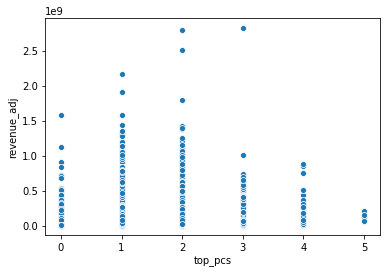

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


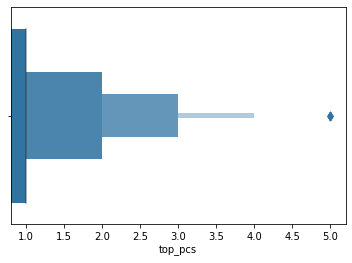

In [90]:
# Creating a new column called 'top_pcs' that will represent the number of top production companies 
# involved in a movie

movies['top_pcs'] = [len(set(i) & set(top_pcs)) for i in movies['production_companies']]
sns.scatterplot(x='top_pcs', y='revenue_adj', data=movies)
plt.show()

sns.boxenplot(x='top_pcs', data=movies)

In [91]:
# Importing the book__film_adaptations 

book_film_adaptations = pd.read_csv('book_film_adaptations.csv')
book_films = pd.DataFrame(book_film_adaptations)


# Removing *s and years
book_films['Film_adaptation'] = book_films['Film_adaptation'].apply(lambda x: x.strip('*'))
book_films['Film_adaptation'] = book_films['Film_adaptation'].str.replace(u'\xa0', u' ')
titles_split = book_films['Film_adaptation'].str.split('(', n=1, expand=True)
book_films['Film_adaptation'] = titles_split[0]
book_films['Film_adaptation'] = book_films['Film_adaptation'].str.rstrip()
# book_films['Film_adaptation'] = book_films['Film_adaptation'].str.split('(')

# book_films['Film_adaptation'] = book_films['Film_adaptation'].apply(lambda x: x.split(' (', 1)[0])

# Converting the series to a list so we can compare it to the cast lists
book_films = book_films['Film_adaptation'].tolist()
print('\n Testing the list: ', book_films[72:77], '\n')

movies['books'] = [len(set(i) & set(book_films)) for i in movies['original_title']]
print('Number of movies adapted from books: \n', movies.books.value_counts())


 Testing the list:  ['Tom Sawyer', ' Huckleberry Finn', 'Tom Sawyer', 'The Adventures of Mark Twain', 'Back to Hannibal: The Return of Tom Sawyer and Huckleberry Finn'] 

Number of movies adapted from books: 
 0    4451
1     397
Name: books, dtype: int64


In [92]:
# Normalizing new feature

movies['norm_winsorized_top_1000_stars'] = normalize(np.array(winsorize(movies['top_1000_stars'], (0, 0.10))).reshape(1,-1)).reshape(-1,1)
movies['norm_winsorized_top_pcs'] = normalize(np.array(winsorize(movies['top_pcs'], (0, 0.10))).reshape(1,-1)).reshape(-1,1)

features_to_test = ['norm_winsorized_top_1000_stars', 'top_1000_stars', 'norm_winsorized_top_pcs', 'top_pcs']

# Now run each and one of the featues in above list. Locate the features in your data and calculate the statistics. 
for feat in features_to_test:
    jb_stats = stats.jarque_bera(movies[feat])
    norm_stats = stats.normaltest(movies[feat])
    
    print("Testing for normality on {}:".format(feat))
    print('Jarque-Bera test statistics for', feat, 'is {0} and p value is {1}'.format(jb_stats[0], jb_stats[1]))
    print('Normality test statistics for', feat, 'is {0} and p value is {1}\n'.format(norm_stats[0], norm_stats[1]))

Testing for normality on norm_winsorized_top_1000_stars:
Jarque-Bera test statistics for norm_winsorized_top_1000_stars is 285.6854074833741 and p value is 0.0
Normality test statistics for norm_winsorized_top_1000_stars is 3726.9083415593186 and p value is 0.0

Testing for normality on top_1000_stars:
Jarque-Bera test statistics for top_1000_stars is 198.49302586769141 and p value is 0.0
Normality test statistics for top_1000_stars is 625.5989558126938 and p value is 1.4220432429128338e-136

Testing for normality on norm_winsorized_top_pcs:
Jarque-Bera test statistics for norm_winsorized_top_pcs is 212.00026473128594 and p value is 0.0
Normality test statistics for norm_winsorized_top_pcs is 1227.1251974830047 and p value is 3.413100405053702e-267

Testing for normality on top_pcs:
Jarque-Bera test statistics for top_pcs is 892.9157555077314 and p value is 0.0
Normality test statistics for top_pcs is 601.6977991126896 and p value is 2.202840416175467e-131



In [93]:
movies.corr().loc[:, ["norm_winsorized_revenue_adj"]].sort_values(by='norm_winsorized_revenue_adj', ascending=False)

,norm_winsorized_revenue_adj
norm_winsorized_revenue_adj,1.000
revenue_adj,0.808
revenue,0.761
budget_adj,0.658
norm_winsorized_vc_pop,0.641
budget,0.607
vote_count,0.583
popularity,0.498
norm_winsorized_top_pcs,0.365
top_pcs,0.346


# Round 3 - Testing Our Models With Three New Variables

In [95]:
features3 = movies[['budget_adj', 'norm_winsorized_vc_pop', 'norm_winsorized_top_pcs', 'runtime', 'top_1000_stars',
                    'Adventure', 'vote_average', 'Action', 'Family', 'Animation', 'Fantasy', 'homepage_dummy', 'Science Fiction',
                    'War', 'tagline_length', 'books', 'Western', 'Thriller', 'History', 'TV Movie', 'Mystery', 'Comedy',
                    'Crime', 'Music', 'Romance', 'Foreign', 'Horror', 'Documentary', 'release_year', 'Drama']]

target = movies['norm_winsorized_revenue_adj'] 
X_train, X_test, Y_train, Y_test = train_test_split(features3, target, test_size = .3, random_state = 465)
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

## Random Forests
While slightly better than the last Random Forest model, I wouldn't say it's significant.

In [98]:
rfr = ensemble.RandomForestRegressor(n_estimators=200)
rfr.fit(features3 ,target)

print('Feature Importance: ', rfr.feature_importances_)
print(cross_val_score(rfr, features3, target, cv=10))

Feature Importance:  [2.55717630e-01 4.35812894e-01 1.34381162e-02 4.17438691e-02
 1.63189243e-02 4.40496905e-03 3.92007469e-02 4.75605120e-03
 3.99701450e-03 1.72919374e-03 3.14802729e-03 4.42996113e-03
 5.12974591e-03 1.37971547e-03 4.77945479e-03 3.27274363e-03
 1.11635176e-03 5.57130483e-03 1.03659046e-03 4.28714982e-05
 3.27376064e-03 7.69449502e-03 3.89225997e-03 2.77598158e-03
 5.87668327e-03 1.59155534e-05 3.62418991e-03 3.08806464e-04
 1.21206343e-01 4.30538898e-03]
[0.77274573 0.75704207 0.78576708 0.74892067 0.75850611 0.74385311
 0.72519803 0.64136849 0.58119909 0.44227391]


## OLS

The OLS is a fine model, but clearly the Random Forests is a higher performer with this data.

In [99]:
print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

# We fit an OLS model using sklearn

ols = LinearRegression().fit(X_train_const, Y_train)

results_train = sm.OLS(Y_train, X_train_const).fit()
results_test = sm.OLS(Y_test, X_test_const).fit()
# We print the summary results
print(results_train.summary())
print('\n')
print(results_test.summary())
print('\n')

# We are making predictions here
Y_preds_train = ols.predict(X_train_const)
Y_preds_test = ols.predict(X_test_const)


print("R-squared of the model on the training set is: {}".format(ols.score(X_train_const, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ols.score(X_test_const, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

The number of observations in training set is 3393
The number of observations in test set is 1455
                                 OLS Regression Results                                
Dep. Variable:     norm_winsorized_revenue_adj   R-squared:                       0.638
Model:                                     OLS   Adj. R-squared:                  0.635
Method:                          Least Squares   F-statistic:                     197.3
Date:                         Sun, 01 Dec 2019   Prob (F-statistic):               0.00
Time:                                 17:53:40   Log-Likelihood:                 12281.
No. Observations:                         3393   AIC:                        -2.450e+04
Df Residuals:                             3362   BIC:                        -2.431e+04
Df Model:                                   30                                         
Covariance Type:                     nonrobust                                         
                      

## Ridge Regression with Training Sets
Similar to the two previous models, the Ridge has improved slightly.

In [101]:
ridgeregr.fit(X_train_const, Y_train)

# We are making predictions here
Y_preds_train = ridgeregr.predict(X_train_const)
Y_preds_test = ridgeregr.predict(X_test_const)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train_const, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test_const, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

R-squared of the model on the training set is: 0.6289929595717147
-----Test set statistics-----
R-squared of the model on the test set is: 0.6340574976021776
Mean absolute error of the prediction is: 0.004760912274894502
Mean squared error of the prediction is: 4.3157508207337785e-05
Root mean squared error of the prediction is: 0.006569437434616284
Mean absolute percentage error of the prediction is: 1598557.4323939527


## ElasticNet With Training/Testing Sets
This model is comparable to the OLS model.

In [102]:

elasticregr = ElasticNet(l1_ratio=1000, alpha=0) 
elasticregr.fit(X_train_const, Y_train)

# We are making predictions here
Y_preds_train = elasticregr.predict(X_train_const)
Y_preds_test = elasticregr.predict(X_test_const)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train_const, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test_const, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

R-squared of the model on the training set is: 0.6377491502712467
-----Test set statistics-----
R-squared of the model on the test set is: 0.6407327930472646
Mean absolute error of the prediction is: 0.004665171816466486
Mean squared error of the prediction is: 4.237025579454054e-05
Root mean squared error of the prediction is: 0.006509243872719821
Mean absolute percentage error of the prediction is: 1620689.7579724737


## Gradient Boosting
Once again, this is our best model. However, it performed better in the last round with fewer variables.

In [111]:
gbr = ensemble.GradientBoostingRegressor(n_estimators=300, max_depth=2, loss='ls')

gbr.fit(X_train_const, Y_train)

Y_preds_train = gbr.predict(X_train_const)
Y_preds_test = gbr.predict(X_test_const)


print("R-squared of the model on the training set is: {}".format(gbr.score(X_train_const, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(gbr.score(X_test_const, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(sqrt(mean_squared_error(Y_test, Y_preds_test))))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

R-squared of the model on the training set is: 0.7654151774435588
-----Test set statistics-----
R-squared of the model on the test set is: 0.7095896468845039
Mean absolute error of the prediction is: 0.004037508457500875
Mean squared error of the prediction is: 3.424960783716954e-05
Root mean squared error of the prediction is: 0.0058523164505321764
Root mean squared error of the prediction is: 0.0058523164505321764
Mean absolute percentage error of the prediction is: 1067085.4848239406


# Last Set of Features
Using the informtion from the OLS models, I'll remove any featrues with a p-value greater than 0.1.

In [113]:
features4 = movies[['budget_adj', 'norm_winsorized_vc_pop', 'norm_winsorized_top_pcs', 'top_1000_stars', 'runtime', 
                    'Family', 'Animation', 'Fantasy', 'Science Fiction', 'TV Movie', 'Comedy',
                     'release_year']]

Y = movies['norm_winsorized_revenue_adj'] 
X_train, X_test, Y_train, Y_test = train_test_split(features4, target, test_size = .3, random_state = 465)
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

## Random Forests with Cross Validation
This model performs slightly worse than the previous Random Forests.

In [114]:
rfr = ensemble.RandomForestRegressor(n_estimators=200)
rfr.fit(features4,Y)

print('Feature Importance: ', rfr.feature_importances_)
print(cross_val_score(rfr, features4, Y, cv=10))

Feature Importance:  [2.72123116e-01 4.55895771e-01 1.84232413e-02 2.43840011e-02
 6.20185193e-02 5.66750494e-03 2.55646299e-03 4.42991462e-03
 7.50807280e-03 4.99453861e-05 1.16513057e-02 1.35292144e-01]
[0.77320582 0.73992874 0.77113833 0.73587163 0.7519201  0.74820942
 0.70474072 0.60262733 0.5596903  0.40653831]


## OLS 

In [117]:
print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

# We fit an OLS model using sklearn

ols = LinearRegression().fit(X_train_const, Y_train)

results_train = sm.OLS(Y_train, X_train_const).fit()
results_test = sm.OLS(Y_test, X_test_const).fit()
# We print the summary results
print(results_train.summary())
print('\n')
print(results_test.summary())
print('\n')

# We are making predictions here
Y_preds_train = ols.predict(X_train_const)
Y_preds_test = ols.predict(X_test_const)


print("R-squared of the model on the training set is: {}".format(ols.score(X_train_const, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ols.score(X_test_const, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

The number of observations in training set is 3393
The number of observations in test set is 1455
                                 OLS Regression Results                                
Dep. Variable:     norm_winsorized_revenue_adj   R-squared:                       0.631
Model:                                     OLS   Adj. R-squared:                  0.630
Method:                          Least Squares   F-statistic:                     482.1
Date:                         Sun, 01 Dec 2019   Prob (F-statistic):               0.00
Time:                                 18:02:04   Log-Likelihood:                 12250.
No. Observations:                         3393   AIC:                        -2.447e+04
Df Residuals:                             3380   BIC:                        -2.440e+04
Df Model:                                   12                                         
Covariance Type:                     nonrobust                                         
                      